**Goal**: compute some characteristics of the files in the datastet using static analysis.

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

In [32]:
#PATH_DIR_FILES = '../data/datasets/exp_v08/files_selected/'

# without loop unrolling
PATH_DIR_FILES = '../data/datasets/exp_v08/intermediate_results/exclude_platform_code/files'
MAGIC_STRING = 'MAGIC_STRING_LINTQ_123456'

PATH_LINTQ_CIRCUIT_SIZE = "../data/analysis_results/exp_v08/codeql_2023-09-22_18-22-09_metrics/data.csv"

DIR_OUTPUT_IMAGES = 'paper_figures'

In [33]:
import os

# List all files in the directory
list_files = os.listdir(PATH_DIR_FILES)#[:1000]
N_FILES_IN_DATASET = len(list_files)
print('Number of files: {}'.format(N_FILES_IN_DATASET))

Number of files: 7587


In [34]:
from multiprocessing import Pool
from functools import partial
from typing import List
from tqdm import tqdm
import ast

def extract_imported_classes(code: str) -> List[str]:
    """Extract all the imported classes from the python code.
    
    e.g.:
    code = '''
    import numpy as np
    import pandas as pd
    from sklearn import linear_model
    from sklearn.linear_model import LogisticRegression
    '''
    extract_imported_classes(code)
    >>> ['numpy', 'pandas', 'sklearn.linear_model', 'sklearn.linear_model.LogisticRegression']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the imported classes
    imported_classes = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            imported_classes += [n.name for n in node.names]
        elif isinstance(node, ast.ImportFrom):
            imported_classes.append(node.module + '.' + node.names[0].name)
    
    return imported_classes


def extract_api_calls(code: str) -> List[str]:
    """Extract all the API calls from the python code.
    
    e.g.:
    code = '''
    import numpy as np
    import pandas as pd

    X = np.array([[1, 2], [3, 4]])
    df = pd.DataFrame(X)
    '''
    extract_api_calls(code)
    >>> ['np.array', 'pd.DataFrame']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the API calls
    api_calls = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            api_calls.append(node.func.attr if hasattr(node.func, 'attr') else node.func.id)
    
    return api_calls


def get_register_sizes(code: str) -> List[str]:
    """Extract all the register sizes from the python code.
    
    e.g.:
    code = '''
    from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)
    qc2 = QuantumCircuit(10)
    '''
    get_register_sizes(code)
    >>> ['2', '2', '10']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the register sizes
    register_sizes = []
    for node in ast.walk(tree):
        # check if the QuantumRegister has integer argument
        if isinstance(node, ast.Call) and hasattr(node.func, 'id') and node.func.id == 'QuantumRegister':
            if len(node.args) == 1 and isinstance(node.args[0], ast.Num):
                n_qubits = node.args[0].n
                register_sizes.append([n_qubits, "q"])

        # check if the ClassicalRegister has integer argument
        if isinstance(node, ast.Call) and hasattr(node.func, 'id') and node.func.id == 'ClassicalRegister':
            if len(node.args) == 1 and isinstance(node.args[0], ast.Num):
                n_bits = node.args[0].n
                register_sizes.append([n_bits, "c"])

        # check if the QuantumCircuit argument is a number
        if isinstance(node, ast.Call) and hasattr(node.func, 'id') and node.func.id == 'QuantumCircuit':
            if len(node.args) == 1 and isinstance(node.args[0], ast.Num):
                n_qubits = node.args[0].n
                register_sizes.append([n_qubits, "q"])
            if len(node.args) == 2 and isinstance(node.args[0], ast.Num) and isinstance(node.args[1], ast.Num):
                n_qubits = node.args[0].n
                n_bits = node.args[1].n
                register_sizes.append([n_qubits, "q"])
                register_sizes.append([n_bits, "c"])
    
    return register_sizes


def read_file(file_name: str, path_dir: str) -> pd.DataFrame:
    """Reads the content of a file.
    
    It returns a dataframe with columns: 'file_name', 'content'
    """
    # Read the file
    with open(os.path.join(path_dir, file_name), 'r') as file:
        content = file.read()
    global MAGIC_STRING
    try: 
        classes = extract_imported_classes(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        classes = [MAGIC_STRING + str(e)]

    try:
        api_calls = extract_api_calls(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        api_calls = [MAGIC_STRING + str(e)]

    try:
        register_sizes = get_register_sizes(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        register_sizes = [MAGIC_STRING + str(e)]

    # Create a dataframe
    df = pd.DataFrame({
        'file_name': [file_name], 
        'content': [content],
        'classes': [classes],
        'api_calls': [api_calls],
        'register_sizes': [register_sizes]
    })
    
    return df


def read_files_in_parallel(list_files: List[str]) -> pd.DataFrame:
    """Reads the content of the files in parallel.
    
    It returns a dataframe with columns: 'file_name', 'content'
    """
    # Create a partial function with the fixed arguments
    read_file_partial = partial(read_file, path_dir=PATH_DIR_FILES)
    
    # Create a pool of workers
    pool = Pool()
    
    # Read the files in parallel
    list_df = list(tqdm(pool.imap(read_file_partial, list_files), total=len(list_files)))
    
    # Close the pool
    pool.close()
    
    # Concatenate the dataframes
    df = pd.concat(list_df, ignore_index=True)
    
    return df

In [35]:
df_all = read_files_in_parallel(list_files)

 13%|█▎        | 959/7587 [00:01<00:11, 560.09it/s] 

100%|██████████| 7587/7587 [00:08<00:00, 874.12it/s] 


In [36]:
n_files = len(df_all)
print(f'Number of files: {n_files}')
df_all.head()

Number of files: 7587


,file_name,content,classes,api_calls,register_sizes
0,qiskit_runner_a05ff0.py,"from typing import List, Optional, Sequence, U...","[typing.List, orquestra.quantum.api.BaseCircui...","[export_to_qiskit, add_register, measure, Clas...",[]
1,01_operator_flow_87f6ae.py,#!/usr/bin/env python\n# coding: utf-8\n\n# # ...,"[qiskit.opflow.I, qiskit.opflow.StateFn, math,...","[print, print, print, print, print, print, pri...",[]
2,graders_f3ed23.py,from qiskit import QuantumCircuit\nfrom qiskit...,"[qiskit.QuantumCircuit, qiskit.compiler.transp...","[Unroller, PassManager, count_ops, isinstance,...",[]
3,challenge4_circuitdecomposition_6c33bd.py,#!/usr/bin/env python\n# coding: utf-8\n\n# # ...,"[may4_challenge.ex4.get_unitary, qiskit.Quantu...","[get_unitary, print, print, array, get_unitary...","[[4, q]]"
4,run_circuit_3a72ed.py,"from qiskit import IBMQ, Aer, BasicAer, execut...","[qiskit.IBMQ, qiskit.providers.ibmq.least_busy...","[measure, execute, job_monitor, result, get_co...",[]


In [37]:
# number of files with errors
for i_attribute in ['classes', 'api_calls', 'register_sizes']:
    n_errors = df_all[df_all[i_attribute].apply(lambda x: MAGIC_STRING in str(x))].shape[0]
    print(f'Number of files with errors in {i_attribute}: {n_errors}')

Number of files with errors in classes: 48
Number of files with errors in api_calls: 164
Number of files with errors in register_sizes: 0


In [38]:
# df = df_all.copy()
# # keep two lines
# df = df.head(4)

def get_dataset_level_list(df: pd.DataFrame, attribute: str) -> pd.DataFrame:
    """Explode the given attribute and return a list of all the values.
    
    Note that this will drop the element with empty lists on that attribute.
    """
    # Keep only the columns of interest
    df = df[['file_name', attribute]]
    # Explode the attribute
    df = df.explode(attribute)
    # Drop NaN values
    df = df.dropna(subset=[attribute])
    # rename the attribute by removing the 's' at the end
    if attribute[-1] == 's':
        df = df.rename(columns={attribute: attribute[:-1]})
    return df

df_classes = get_dataset_level_list(df_all, 'classes')
df_api_calls = get_dataset_level_list(df_all, 'api_calls')
df_register_sizes = get_dataset_level_list(df_all, 'register_sizes')

df_register_sizes.head()

,file_name,register_size
3,challenge4_circuitdecomposition_6c33bd.py,"[4, q]"
6,game2_ec0ca2.py,"[1, q]"
8,circuit_basics_49646b.py,"[3, q]"
8,circuit_basics_49646b.py,"[3, q]"
8,circuit_basics_49646b.py,"[3, c]"


## LintQ for Circuit Size

In [39]:
df_circuit_size = pd.read_csv(PATH_LINTQ_CIRCUIT_SIZE)
df_circuit_size.head()

,Tool,Severity,Code,Location,Line
0,CodeQL,warning,ql-qc-size Circuit 'A' has 0 qubits and 0 clas...,utils_6c4393.py,380
1,CodeQL,warning,ql-qc-size Circuit 'A' has 0 qubits and 0 clas...,utils_6c4393.py,427
2,CodeQL,warning,ql-qc-size Circuit 'A' has 0 qubits and 0 clas...,utils_6c4393.py,474
3,CodeQL,warning,ql-qc-size Circuit 'A' has 0 qubits and 0 clas...,utils_6c4393.py,521
4,CodeQL,warning,ql-qc-size Circuit 'A' has 0 qubits and 1 clas...,utils_6c4393.py,61


In [40]:
df_circuit_size.iloc[0]["Code"]

"ql-qc-size Circuit 'A' has 0 qubits and 0 classical bits."

In [41]:
import re
# filter and extract number of qubits 
# e.g. ql-qc-size Circuit 'A' has 0 qubits ... -> 0
df_circuit_size['n_qubits'] = df_circuit_size['Code'].apply(
    lambda x: int(re.findall(r'(\d+) qubits', x)[0]))
# same for bit
df_circuit_size['n_clbits'] = df_circuit_size['Code'].apply(
    lambda x: int(re.findall(r'(\d+) classical bits', x)[0]))
df_circuit_size.head()

import pandas as pd

# Assuming df_circuit_size is the DataFrame containing the qubit and bit counts
median_qubits = df_circuit_size['n_qubits'].median()
mean_qubits = df_circuit_size['n_qubits'].mean()
min_qubits = df_circuit_size['n_qubits'].min()
max_qubits = df_circuit_size['n_qubits'].max()

median_clbits = df_circuit_size['n_clbits'].median()
mean_clbits = df_circuit_size['n_clbits'].mean()
min_clbits = df_circuit_size['n_clbits'].min()
max_clbits = df_circuit_size['n_clbits'].max()

print("\\newcommand{\\medianCircSizeQubit}{" + str(median_qubits) + r"}")
print("\\newcommand{\\meanCircSizeQubit}{" + f"{mean_qubits:.1f}" + r"}")
print("\\newcommand{\\minCircSizeQubit}{" + str(min_qubits) + r"}")
print("\\newcommand{\\maxCircSizeQubit}{" + str(max_qubits) + r"}")
print("\\newcommand{\\medianCircSizeClbit}{" + str(median_clbits) + r"}")
print("\\newcommand{\\meanCircSizeClbit}{" + f"{mean_clbits:.1f}" + r"}")
print("\\newcommand{\\minCircSizeClbit}{" + str(min_clbits) + r"}")
print("\\newcommand{\\maxCircSizeClbit}{" + str(max_clbits) + r"}")



\newcommand{\medianCircSizeQubit}{2.0}
\newcommand{\meanCircSizeQubit}{12.4}
\newcommand{\minCircSizeQubit}{0}
\newcommand{\maxCircSizeQubit}{20000}
\newcommand{\medianCircSizeClbit}{0.0}
\newcommand{\meanCircSizeClbit}{2.1}
\newcommand{\minCircSizeClbit}{0}
\newcommand{\maxCircSizeClbit}{4200}


In [42]:
# separate the pairs in the register_sizes in two columns 
# e.g. register_size: [4, q] -> n_qubits: 4, reg_type: quantum
# c -> classical

df_register_sizes['size'] = df_register_sizes['register_size'].apply(lambda x: x[0])
df_register_sizes['reg_type'] = df_register_sizes['register_size'].apply(lambda x: x[1])
# df_register_sizes = df_register_sizes.drop(columns=['register_size'])
df_register_sizes['is_size_an_int'] = df_register_sizes['size'].apply(lambda x: isinstance(x, int))
count = df_register_sizes['is_size_an_int'].value_counts()
# filter only true
df_register_sizes = df_register_sizes[df_register_sizes['is_size_an_int'] == True]
# cast to int
df_register_sizes['size'] = df_register_sizes['size'].astype(int)
print(f'Number of files with integer size: {count}')
df_register_sizes.head()


Number of files with integer size: is_size_an_int
True    8024
Name: count, dtype: int64


,file_name,register_size,size,reg_type,is_size_an_int
3,challenge4_circuitdecomposition_6c33bd.py,"[4, q]",4,q,True
6,game2_ec0ca2.py,"[1, q]",1,q,True
8,circuit_basics_49646b.py,"[3, q]",3,q,True
8,circuit_basics_49646b.py,"[3, q]",3,q,True
8,circuit_basics_49646b.py,"[3, c]",3,c,True


# Gate Analysis

In [43]:
# gate mapping list

map_to_lower_gate_name = {
    'C3XGate': 'mcx',
    'C3SXGate': 'mcx',
    'C4XGate': 'mcx',
    'CCXGate': 'ccx',
    'DCXGate': 'dcx',
    'CHGate': 'ch',
    'CPhaseGate': 'cp',
    'CRXGate': 'crx',
    'CRYGate': 'cry',
    'CRZGate': 'crz',
    'CCZGate': 'ccz',
    'CSwapGate': 'cswap',
    'CSXGate': 'csx',
    'CUGate': 'cu',
    'CU1Gate': 'cu1',
    'CU3Gate': 'cu3',
    'CXGate': 'cx',
    'CYGate': 'cy',
    'CZGate': 'cz',
    'HGate': 'h',
    'IGate': 'id',
    'PhaseGate': 'p',
    'RGate': 'r',
    'RCCXGate': 'rccx',
    'RC3XGate': 'rcccx',
    'RXGate': 'rx',
    'RXXGate': 'rxx',
    'RYGate': 'ry',
    'RYYGate': 'ryy',
    'RZGate': 'rz',
    'RZZGate': 'rzz',
    'RZXGate': 'rzx',
    'ECRGate': 'ecr',
    'SGate': 's',
    'SdgGate': 'sdg',
    'SwapGate': 'swap',
    'iSwapGate': 'iswap',
    'SXGate': 'sx',
    'SXdgGate': 'sxdg',
    'TGate': 't',
    'TdgGate': 'tdg',
    'UGate': 'u',
    'U1Gate': 'u1',
    'U2Gate': 'u2',
    'U3Gate': 'u3',
    'XGate': 'x',
    'YGate': 'y',
    'ZGate': 'z',
    'CSdgGate': 'csdg',
    'CSGate': 'cs',
    'MSGate': 'ms',
    'Barrier': 'barrier',
    'Measure': 'measure',
    'Reset': 'reset',
    'measure_all': 'measure_all'    
}

In [44]:
df_api_calls.head()

,file_name,api_call
0,qiskit_runner_a05ff0.py,export_to_qiskit
0,qiskit_runner_a05ff0.py,add_register
0,qiskit_runner_a05ff0.py,measure
0,qiskit_runner_a05ff0.py,ClassicalRegister
0,qiskit_runner_a05ff0.py,isinstance


/tmp/ipykernel_34999/2613087748.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gate_calls['api_call'] = df_gate_calls['api_call'].apply(
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Number of unique files that call gate-related API calls: 4992
\newcommand{\avgGateCallsPerFile}{8.7}
\newcommand{\avgGateCallsPerFileNoMeasure}{7.8}
\newcommand{\avgMeasureCallsPerFile}{0.9}
\newcommand{\topFirstGateName}{h}
\newcommand{\topSecondGateName}{cx}
\newcommand{\topThridGateName}{x}


/tmp/ipykernel_34999/2613087748.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = gate_counts[i]


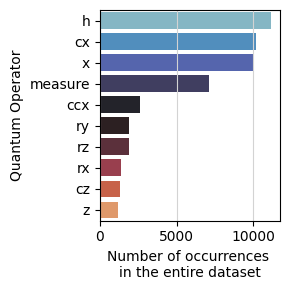

In [50]:
# filter all API calls related to gates
top_k = 10

api_gate_calls_names_curated = list(map_to_lower_gate_name.values()) + list(map_to_lower_gate_name.keys())
api_gate_calls_names_curated = list(set(api_gate_calls_names_curated))

df_api_calls['is_gate_call'] = df_api_calls['api_call'].apply(
    lambda x: x in api_gate_calls_names_curated)

# filter all API calls related to gates
df_gate_calls = df_api_calls[df_api_calls['is_gate_call'] == True]

# normalize names with the curated list
df_gate_calls['api_call'] = df_gate_calls['api_call'].apply(
    lambda x: map_to_lower_gate_name[x] if x in map_to_lower_gate_name.keys() else x)

n_unique_files = df_gate_calls['file_name'].nunique()
print(f'Number of unique files that call gate-related API calls: {n_unique_files}')

n_gate_api_calls = df_gate_calls.shape[0]
n_gate_calls_per_file = n_gate_api_calls / N_FILES_IN_DATASET
print("\\newcommand{\\avgGateCallsPerFile}{" + f"{n_gate_calls_per_file:.1f}" + "}")

# exclude the measure gate
df_tmp = df_gate_calls[df_gate_calls['api_call'] != 'measure']
n_gate_api_calls_no_measure = df_tmp.shape[0]
n_gate_calls_per_file_no_measure = n_gate_api_calls_no_measure / N_FILES_IN_DATASET
print("\\newcommand{\\avgGateCallsPerFileNoMeasure}{" + f"{n_gate_calls_per_file_no_measure:.1f}" + "}")

# consider only measure
df_measure_call_only = df_gate_calls[df_gate_calls['api_call'] == 'measure']
n_measure_api_calls = df_measure_call_only.shape[0]
n_measure_calls_per_file = n_measure_api_calls / N_FILES_IN_DATASET
print("\\newcommand{\\avgMeasureCallsPerFile}{" + f"{n_measure_calls_per_file:.1f}" + "}")

# remove barrier
df_gate_calls_no_barrier = df_gate_calls[df_gate_calls['api_call'] != 'barrier']

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data=df_gate_calls_no_barrier,
    y='api_call',
    order=df_gate_calls_no_barrier['api_call'].value_counts().iloc[:top_k].index,
    palette="icefire",
    ax=ax
)
ax.set_xlabel('Number of occurrences \nin the entire dataset')
ax.set_ylabel('Quantum Operator')
ax.grid(axis='x', color='lightgray')
plt.tight_layout()
df_gate_calls.head()

fig.savefig(os.path.join(DIR_OUTPUT_IMAGES, 'gate_calls.pdf'), bbox_inches='tight')

# print top 3 names of gate with new command
top_k = 3
top_k = 3

# Get the counts of each gate name
gate_counts = df_gate_calls_no_barrier['api_call'].value_counts()

map_latex_index = {
    1: "First", 
    2: "Second",
    3: "Thrid"
}

# Print the top k gate names and their counts
for i in range(top_k):
    gate_name = gate_counts.index[i]
    count = gate_counts[i]
    # map 1 -> first, 2 -> second, 3 -> thrird

    latex_index = map_latex_index[i + 1]
    print("\\newcommand{\\top" + latex_index + "GateName}{" + gate_name + "}")

In [46]:
top_k = 3

# Get the counts of each gate name
gate_counts = df_gate_calls['api_call'].value_counts()

# Print the top k gate names and their counts
for i in range(top_k):
    gate_name = gate_counts.index[i]
    count = gate_counts[i]
    print(f"Gate name: {gate_name}, count: {count}")

Gate name: h, count: 11179
Gate name: cx, count: 10145
Gate name: x, count: 10041


/tmp/ipykernel_34999/2628701858.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = gate_counts[i]


In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram_of(
        column: str, 
        df: pd.DataFrame, 
        latex_variable_name: str = "Empty",
        color: str = None,
        x_label: str = None,
        y_label: str = None,
        hue: str = None,):
    """Plot the histogram of the given column."""
    fig, ax = plt.subplots(figsize=(5, 3))
    kwargs = {}
    if hue is not None:
        kwargs["hue"] = hue
    if color is not None:
        kwargs["color"] = color
    sns.histplot(
        data=df,
        x=column,
        #bins=20,
        ax=ax,
        **kwargs
    )
    mean_val = df[column].mean()
    ax.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:.2f}")
    print("\\newcommand{\\mean" + latex_variable_name + "}{" + f"{mean_val:.2f}" + "}")
    median_val = df[column].median()
    ax.axvline(median_val, color="green", linestyle="--", label=f"Median: {median_val:.2f}")
    print("\\newcommand{\\median" + latex_variable_name + "}{" + f"{median_val:.2f}" + "}")
    plt.legend()

    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)
    # show the legend
    ax.set_xlim(0, df[column].max())
    return fig, ax

In [91]:
df_register_sizes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8024 entries, 3 to 7582
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_name       8024 non-null   object
 1   register_size   8024 non-null   object
 2   size            8024 non-null   int64 
 3   reg_type        8024 non-null   object
 4   is_size_an_int  8024 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 321.3+ KB


\newcommand{\nQuantumRegLargerThanCap}{45}
\newcommand{\percQuantumRegLargerThanCap}{0.86\%}
\newcommand{\meanQuantumRegisterSize}{2.94}
\newcommand{\medianQuantumRegisterSize}{2.00}
\newcommand{\nClassicalRegLargerThanCap}{21}
\newcommand{\percClassicalRegLargerThanCap}{0.76\%}
\newcommand{\meanClassicalRegisterSize}{2.73}
\newcommand{\medianClassicalRegisterSize}{2.00}


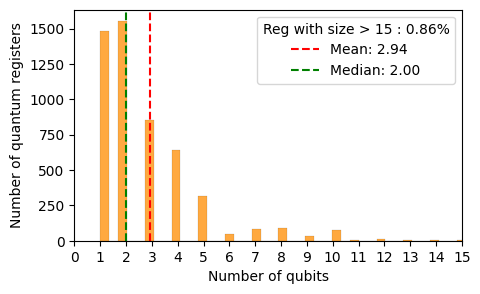

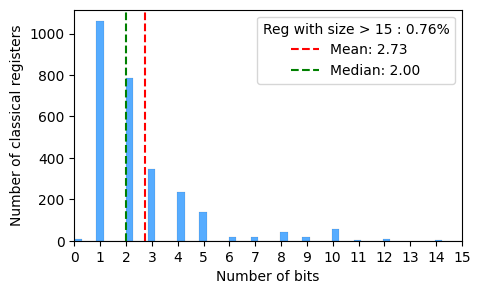

In [107]:
df_quantum_registers = df_register_sizes[df_register_sizes['reg_type'] == 'q']
df_classical_registers = df_register_sizes[df_register_sizes['reg_type'] == 'c']

CAP_VALUE = 15

# quantum registers
# count the number of files with more than CAP_VALUE
n_reg_larger_than_cap = df_quantum_registers[
    df_quantum_registers['size'] > CAP_VALUE].shape[0]
perc_reg_larger_than_cap = n_reg_larger_than_cap / df_quantum_registers.shape[0] * 100
print(f"\\newcommand{{\\nQuantumRegLargerThanCap}}{{{n_reg_larger_than_cap}}}")
print(f"\\newcommand{{\\percQuantumRegLargerThanCap}}{{{perc_reg_larger_than_cap:.2f}\%}}")

fig, ax = plot_histogram_of(
    column='size',
    df=df_quantum_registers,
    latex_variable_name='QuantumRegisterSize',
    color='darkorange',
    x_label='Number of qubits',
    y_label='Number of quantum registers',
)
ax.set_xlim(0, CAP_VALUE)
ax.set_xticks(range(0, CAP_VALUE + 1, 1))
ax.set_xticklabels(range(0, CAP_VALUE + 1, 1))
# write the percentage of registers with size larger than CAP_VALUE in legend
ax.legend(
    title=f"Reg with size > {CAP_VALUE} : {perc_reg_larger_than_cap:.2f}%",
    loc='upper right',
)
    
# classical registers
# count the number of files with more than CAP_VALUE
n_reg_larger_than_cap = df_classical_registers[
    df_classical_registers['size'] > CAP_VALUE].shape[0]
perc_reg_larger_than_cap = n_reg_larger_than_cap / df_classical_registers.shape[0] * 100
print(f"\\newcommand{{\\nClassicalRegLargerThanCap}}{{{n_reg_larger_than_cap}}}")
print(f"\\newcommand{{\\percClassicalRegLargerThanCap}}{{{perc_reg_larger_than_cap:.2f}\%}}")


fig, ax = plot_histogram_of(
    column='size',
    df=df_classical_registers,
    latex_variable_name='ClassicalRegisterSize',
    color='dodgerblue',
    x_label='Number of bits',
    y_label='Number of classical registers',
)
ax.set_xlim(0, CAP_VALUE)
ax.set_xticks(range(0, CAP_VALUE + 1, 1))
ax.set_xticklabels(range(0, CAP_VALUE + 1, 1))
# write the percentage of registers with size larger than CAP_VALUE in legend
ax.legend(
    title=f"Reg with size > {CAP_VALUE} : {perc_reg_larger_than_cap:.2f}%",
    loc='upper right',
)


In [33]:
# check names in the qiskit doc but not in the curated one
missing_names = []
for name in api_gate_calls_names_qiskit_doc:
    if name not in api_gate_calls_names_curated:
        missing_names.append(name)
missing_names

['XXMinusYYGate', 'XXPlusYYGate', 'GlobalPhaseGate']

In [10]:
# get unique calls, remove the "Gate" part and lowecase
unique_gate_calls = df_gate_calls['api_calls'].unique()
unique_gate_calls = [i_call.replace('Gate', '').lower() for i_call in unique_gate_calls]
unique_gate_calls[:7]

['h', 'passthroughh', 'z', 'passthroughz', 'cx', 'swap', 'rzz']

Number of unique files with direct API calls: 5534


<AxesSubplot: xlabel='count', ylabel='api_calls'>

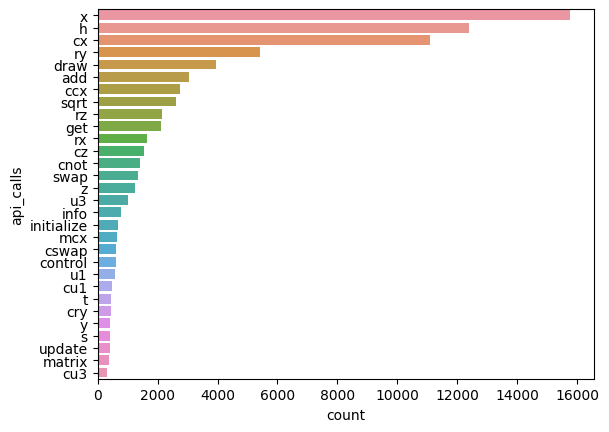

In [11]:
top_k = 30

df_direct_gate_calls = df_api_calls[df_api_calls['api_calls'].apply(lambda x: x in unique_gate_calls)]
n_unique_files = df_direct_gate_calls['file_name'].nunique()
print(f'Number of unique files with direct API calls: {n_unique_files}')
sns.countplot(
    data=df_direct_gate_calls,
    y='api_calls',
    order=df_direct_gate_calls['api_calls'].value_counts().iloc[:top_k].index
)

Number of unique classes: 7227


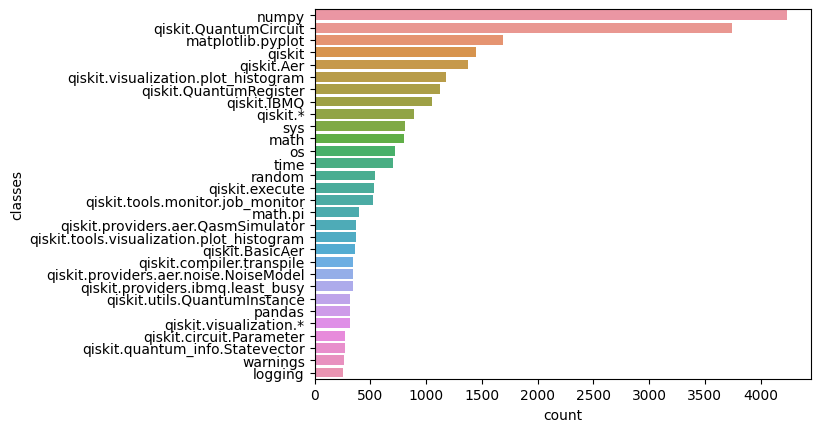

Number of unique api_calls: 19816


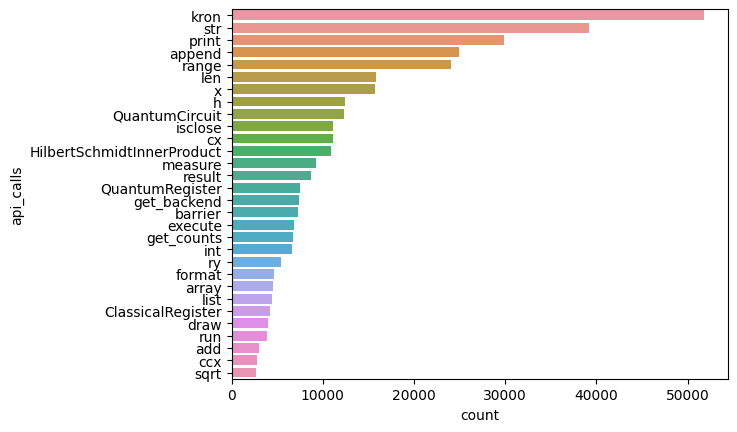

In [82]:
top_k = 30

for (i_df, i_attribute) in zip(
    [df_classes, df_api_calls],
    ['classes', 'api_calls']
):
    print(f'Number of unique {i_attribute}: {i_df[i_attribute].nunique()}')

    sns.countplot(
        data=i_df,
        y=i_attribute,
        order=i_df[i_attribute].value_counts().iloc[:top_k].index
    )
    plt.show()

In [ ]:
df = df_register_sizes.copy()

df['register_is_int'] = df['register_sizes'].apply(lambda x: isinstance(x, int))
# filter out the files with errors
df = df[df['register_is_int'] == True]

sns.histplo


In [51]:
# filter all the relevant_api_calls which contain measure
measurement_related_calls = [
    i_call for i_call in df_api_calls['api_calls'].unique()
    if 'measure' in i_call.lower()
]
measurement_related_calls

['measure',
 '_run_batch_and_measure',
 'Measurements',
 'measure_all',
 'measure_message',
 'perform_measurement',
 'remove_last_measurements',
 'Measurement',
 'run_and_measure',
 'run_batch_and_measure',
 'get_measurement_outcome_distribution',
 'MeasurementTrackingBackend',
 'MeasureCircuit',
 'qpe_measure',
 'remove_final_measurements',
 'get_measurement_qubits_from_transpiled_circuit',
 'MeasureZ',
 'obtain_measurements_linear',
 'obtain_measurements_cyclic',
 'obtain_measurements_square_lattice',
 'measures_exploitation',
 'final_measurement_mapping',
 'measure_bits',
 'Measure_PauliWord',
 'change_basis_for_Z_measure',
 'append_measurements',
 'prepare_and_measure_single_qubit_in_qiskit_quantum_register_in_z_basis',
 'prepare_and_measure_single_qubit_in_qiskit_quantum_register_in_x_basis',
 '_bell_state_measurement',
 'measure_1qubit',
 'measure_2qubit',
 'measure_xy',
 'extract_measurement_idx',
 'measure_node_to_circuit',
 '_calculate_measurements',
 'add_random_measurements'

In [65]:
# compute the number of gate api calls per file
api_calls_gate_obj = list(df_gate_calls['api_calls'].unique())
api_calls_gate_call = [
    i_call.replace('Gate', '').lower() for i_call in api_calls_gate_obj]
relevant_api_calls = api_calls_gate_call + api_calls_gate_obj
print(f'Number of relevant API calls: {len(relevant_api_calls)}')
print(f'Relevant API calls: {relevant_api_calls[:5]}')

df = df_all.copy()
# keep only the columns of interest
df = df[['file_name', 'api_calls']]
# keep on those with relevant api calls (at least one)
df['has_gate'] = df['api_calls'].apply(lambda x: any(i_call in x for i_call in relevant_api_calls))
# count the gate calls per file
df['api_calls_gate'] = df['api_calls'].apply(
    lambda x: [i_call for i_call in x if i_call in relevant_api_calls]
)
df['n_api_calls_gate'] = df['api_calls_gate'].apply(lambda x: len(x))
# count how many include measurement gate calls
# list of gate calls with measure: measurement_related_calls
df['has_measure'] = df['api_calls_gate'].apply(lambda x: any(i_call in x for i_call in measurement_related_calls))
# get the measruement calls
df['api_calls_measure'] = df['api_calls_gate'].apply(
    lambda x: [i_call for i_call in x if i_call in measurement_related_calls]
)
df['n_api_calls_measure'] = df['api_calls_measure'].apply(lambda x: len(x))

df_files_and_gate_calls = df
df_files_and_gate_calls.head()



Number of relevant API calls: 484
Relevant API calls: ['h', 'passthroughh', 'z', 'passthroughz', 'cx']


,file_name,api_calls,has_gate,api_calls_gate,n_api_calls_gate,has_measure,api_calls_measure,n_api_calls_measure
0,qiskit_runner_a05ff0.py,"[export_to_qiskit, add_register, measure, Clas...",False,[],0,False,[],0
1,01_operator_flow_87f6ae.py,"[print, print, print, print, print, print, pri...",True,"[draw, sqrt]",2,False,[],0
2,graders_f3ed23.py,"[Unroller, PassManager, count_ops, isinstance,...",False,[],0,False,[],0
3,challenge4_circuitdecomposition_6c33bd.py,"[get_unitary, print, print, array, get_unitary...",True,"[h, h, h, h]",4,False,[],0
4,run_circuit_3a72ed.py,"[measure, execute, job_monitor, result, get_co...",True,"[apply, apply]",2,False,[],0


\newcommand{\dataLintQAvgGateCallPerFile}{11}
\newcommand{\dataLintQMedianGateCallPerFile}{3}
\newcommand{\dataLintQMaxGateCallPerFile}{5010}


\newcommand{\dataLintQAvgGateCallPerFile}{11}
\newcommand{\dataLintQMedianGateCallPerFile}{3}
\newcommand{\dataLintQMaxGateCallPerFile}{5010}
Number of files with more than 50 API calls referring to Gate: 207


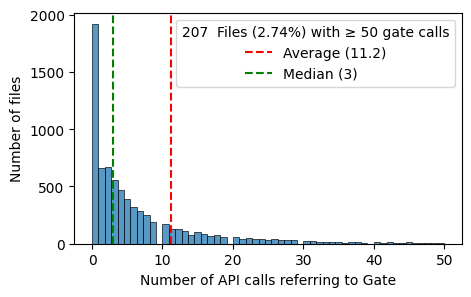

In [79]:
CAP_VALUE = 50

df = df_files_and_gate_calls


avg_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].mean()
median_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].median()
max_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].max()
print("\\newcommand{\\dataLintQAvgGateCallPerFile}{" + f"{avg_api_calls_gate:.0f}" + "}")
print("\\newcommand{\\dataLintQMedianGateCallPerFile}{" + f"{median_api_calls_gate:.0f}" + "}")
print("\\newcommand{\\dataLintQMaxGateCallPerFile}{" + f"{max_api_calls_gate:.0f}" + "}")

# count the number of files with more than CAP_VALUE
n_files_with_many_calls = df[df['n_api_calls_gate'] > CAP_VALUE].shape[0]
print(f'Number of files with more than {CAP_VALUE} API calls referring to Gate: {n_files_with_many_calls}')
perc_files_with_many_calls = (n_files_with_many_calls / df.shape[0]) * 100

# filter the files with less than CAP_VALUE
df = df[df['n_api_calls_gate'] <= CAP_VALUE]

fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(
    data=df,
    x='n_api_calls_gate',
    ax=ax,
)
ax.set_xlabel('Number of API calls referring to Gate')
ax.set_ylabel('Number of files')

ax.axvline(avg_api_calls_gate, color='red', linestyle='--', label=f'Average ({avg_api_calls_gate:.1f})')
ax.axvline(median_api_calls_gate, color='green', linestyle='--', label=f'Median ({median_api_calls_gate:.0f})')

# add to the legend title
ax.legend(title=f'{n_files_with_many_calls}  Files ({perc_files_with_many_calls:.2f}%) with ≥ {CAP_VALUE} gate calls')

plt.show()

# Measurements

\newcommand{\dataLintQAvgMeasureCallPerFile}{2}
\newcommand{\dataLintQMedianMeasureCallPerFile}{0}
\newcommand{\dataLintQMaxMeasureCallPerFile}{625}
Number of files with more than 10 API calls referring to measurement: 129 (1.70%)


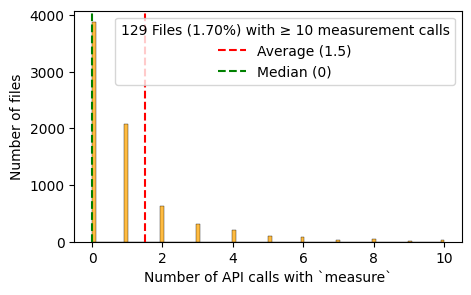

In [80]:
CAP_VALUE = 10

df = df_all.copy()
df['api_measure'] = df['api_calls'].apply(lambda x: [i_call for i_call in x if i_call in measurement_related_calls])
df['n_api_measure'] = df['api_measure'].apply(lambda x: len(x))

avg_api_calls_measure = df['n_api_measure'].mean()
median_api_calls_measure = df['n_api_measure'].median()
max_api_calls_measure = df['n_api_measure'].max()
print("\\newcommand{\\dataLintQAvgMeasureCallPerFile}{" + f"{avg_api_calls_measure:.0f}" + "}")
print("\\newcommand{\\dataLintQMedianMeasureCallPerFile}{" + f"{median_api_calls_measure:.0f}" + "}")
print("\\newcommand{\\dataLintQMaxMeasureCallPerFile}{" + f"{max_api_calls_measure:.0f}" + "}")

n_files_above_cap = df[df['n_api_measure'] > CAP_VALUE].shape[0]
perc_files_above_cap = (n_files_above_cap / df.shape[0]) * 100
print(f'Number of files with more than {CAP_VALUE} API calls referring to measurement: {n_files_above_cap} ({perc_files_above_cap:.2f}%)')

# filter out the files with more than CAP_VALUE
df = df[df['n_api_measure'] <= CAP_VALUE]

fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(
    data=df,
    x='n_api_measure',
    ax=ax,
    color='orange',
)
ax.set_ylabel('Number of files')
ax.set_xlabel('Number of API calls with `measure`')
ax.axvline(avg_api_calls_measure, color='red', linestyle='--', label=f'Average ({avg_api_calls_measure:.1f})')
ax.axvline(median_api_calls_measure, color='green', linestyle='--', label=f'Median ({median_api_calls_measure:.0f})')
ax.legend(title=f'{n_files_above_cap} Files ({perc_files_above_cap:.2f}%) with ≥ {CAP_VALUE} measurement calls')

